In [1]:
import os, sys
import numpy as np
import anndata as ad

current_dir = os.getcwd()
if os.path.basename(current_dir) == 'simulations':
    project_root = os.path.abspath(os.path.join(current_dir, '..'))
else:
    project_root = current_dir
if project_root not in sys.path:
    sys.path.append(project_root)

from simulations import sim  

In [2]:
output_dir = "simulations/dataset_triple_omics"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [3]:
simulator = sim.SpatialMultiOmics(scenario="ggblocks", nside=36, seed=2024)

config = [
    {
        "name": "RNA",
        "params": {
            "Jsp": 600, "Jmix": 600, "Jns": 0, 
            "expr_mean": 20.0, 
            "nb_shape": 10.0, 
            "dropout_rate": 0.5
        },
        "active_factors": [0, 1, 2, 3] 
    },
    {
        "name": "ATAC",
        "params": {
            "Jsp": 700, "Jmix": 500, "Jns": 300,
            "expr_mean": 20.0, 
            "nb_shape": 10.0, 
            "dropout_rate": 0.2  
        },
        "active_factors": [2, 3, 4, 5]
    },
    {
        "name": "Protein",
        "params": {
            "Jsp": 20, "Jmix": 10, "Jns": 10,
            "expr_mean": 20.0, 
            "nb_shape": 10.0,
            "dropout_rate": 0.0 
        },
        "active_factors": [0, 3, 6, 7, 8]
    }
]

adatas = simulator.generate_data(config)

for name, adata in adatas.items():
    save_path = os.path.join(output_dir, f"adata_{name}.h5ad")
    adata.write_h5ad(save_path, compression="gzip")
    print(f"Saved: {save_path}")

Generated [RNA]: shape=(1296, 1200), dropout=0.5, active_factors=[0, 1, 2, 3]
Generated [ATAC]: shape=(1296, 1500), dropout=0.2, active_factors=[2, 3, 4, 5]
Generated [Protein]: shape=(1296, 40), dropout=0.0, active_factors=[0, 3, 6, 7, 8]
Saved: simulations/dataset_triple_omics\adata_RNA.h5ad
Saved: simulations/dataset_triple_omics\adata_ATAC.h5ad
Saved: simulations/dataset_triple_omics\adata_Protein.h5ad


Processing RNA


d:\Anaconda\envs\sim\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Processing ATAC
Processing Protein


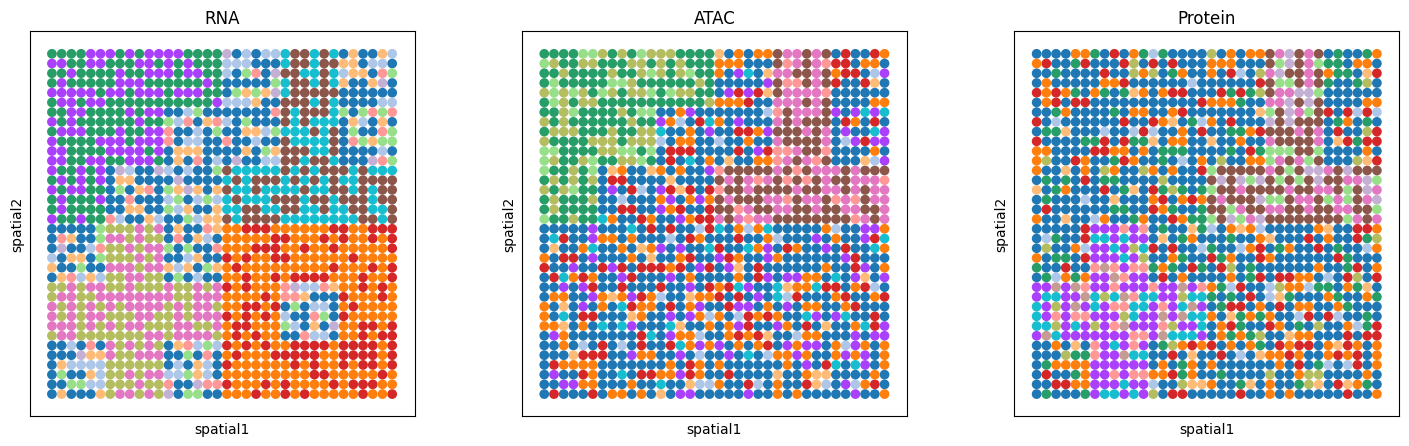

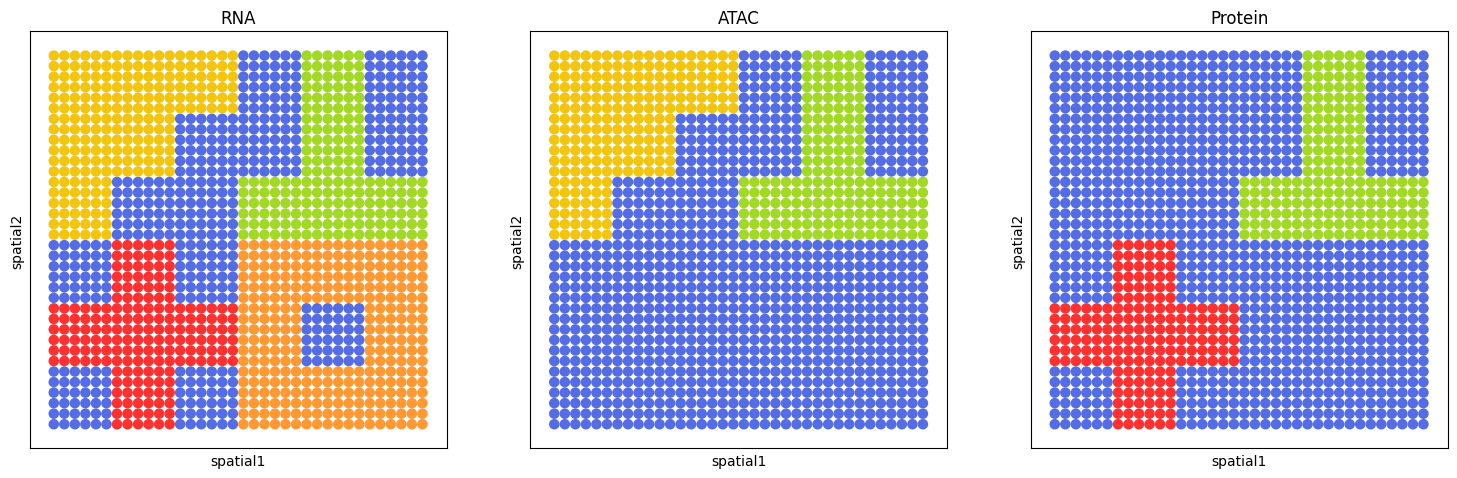

<Figure size 640x480 with 0 Axes>

In [4]:
import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np

n_mods = len(adatas)
fig_truth, axes_truth = plt.subplots(1, n_mods, figsize=(6 * n_mods, 5))
fig_cluster, axes_cluster = plt.subplots(1, n_mods, figsize=(6 * n_mods, 5))

if n_mods == 1:
    axes_truth = [axes_truth]
    axes_cluster = [axes_cluster]
else:
    axes_truth = axes_truth.flatten()
    axes_cluster = axes_cluster.flatten()

palette = {
    "Background": "#546DE5", 
    "Factor 1": "#FF3030",   
    "Factor 2": "#FF9933", 
    "Factor 3": "#F2C511",  
    "Factor 4": "#A2D927",  
    "Factor 5": "#33D676",   
    "Factor 6": "#21C4D4",   
    "Factor 7": "#3892E8",  
    "Factor 8": "#5F27CD", 
    "Factor 9": "#D65DB1",  
    "Overlap": "#FF6FA0" 
}

for idx, (name, adata) in enumerate(adatas.items()):
    print(f"Processing {name}")

    coords = adata.obsm['spatial']
    x_range = coords[:, 0].max() - coords[:, 0].min()
    y_range = coords[:, 1].max() - coords[:, 1].min()
    n_obs = adata.shape[0]
    n_side = int(np.sqrt(n_obs))
    spacing = max(x_range, y_range) / (n_side - 1) if n_side > 1 else 1.0
    spot_size = spacing * 1.0

    factors = adata.obsm['spfac']
    mod_active_factors = adata.uns.get('active_factors', list(range(factors.shape[1])))
    mod_active_factors_set = set(mod_active_factors)

    labels = []
    for i in range(factors.shape[0]):
        spot_factors = np.where(factors[i] == 1)[0]
        visible_factors = [f for f in spot_factors if f in mod_active_factors_set]

        if len(visible_factors) == 0:
            labels.append("Background")
        elif len(visible_factors) == 1:
            labels.append(f"Factor {visible_factors[0]+1}")
        else:
            labels.append("Overlap")

    adata.obs['True_Pattern'] = labels
    adata.obs['True_Pattern'] = adata.obs['True_Pattern'].astype('category')

    n_comps = min(max(adata.n_vars - 1, 1), 50)
    if 'X_pca' not in adata.obsm:
        sc.pp.pca(adata, n_comps=n_comps)
    if 'neighbors' not in adata.uns:
        sc.pp.neighbors(adata)
    sc.tl.leiden(adata, key_added='leiden', resolution=0.5)

    sc.pl.spatial(adata, color='True_Pattern', spot_size=spot_size,
                  title=f"{name}", palette=palette,
                  ax=axes_truth[idx], show=False, legend_loc=None)

    sc.pl.spatial(adata, color='leiden', spot_size=spot_size,
                  title=f"{name}", ax=axes_cluster[idx], show=False, legend_loc=None)

    axes_truth[idx].set_xticks([])
    axes_truth[idx].set_yticks([])
    axes_cluster[idx].set_xticks([])
    axes_cluster[idx].set_yticks([])

fig_truth.tight_layout()
fig_truth.subplots_adjust(right=0.8, wspace=0.2)
plt.figure(fig_truth.number)
plt.show()

fig_cluster.tight_layout()
fig_cluster.subplots_adjust(right=0.8, wspace=0.2)
plt.figure(fig_cluster.number)
plt.show()